In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import random
from jupyterthemes import jtplot
import gudhi as gd

# Jupyter NB customizations
# warnings.filterwarnings('ignore')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
plt.rc('axes', titlesize=20)                                                   # fontsize of the axes title
plt.rc('axes', labelsize=20)                                                   # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)                                                  # fontsize of the tick labels
plt.rc('ytick', labelsize=20)                                                  # fontsize of the tick labels
plt.rc('legend', fontsize=18)                                                  # legend fontsize
plt.rc('figure', titlesize=20)                                                 # fontsize of the figure title
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = [13, 9]

# Extracting and Visualizing dataset

Load halo sample from "halos_0.0.ascii" file with pandas:

In [2]:
loc = r"C:\Users\raul_\OneDrive\Escritorio\Side__Projects\Cosmology_Learning\Cosmic_Web\halos_0.0.ascii"    # path to halo file

# Reading the data
start1 = time.time()

df = pd.read_csv(loc, delimiter=" ", usecols=["x", "y", "z", "m200b", "PosUncertainty"])[18:]
x, y, z, pos_sigma, m200b = df.values.astype(np.float).T 
log_m = np.log10(m200b)

end1 = time.time()
print(f"Exracting the data took {end1-start1:.2f} seconds.")

# Doing a 3-D scatter plot of the positiions as well as plotting the histogram of mass distribution
n_halos = len(x)

Exracting the data took 0.84 seconds.


C:\Users\raul_\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Plot halo mass distribution and spatial distribution,

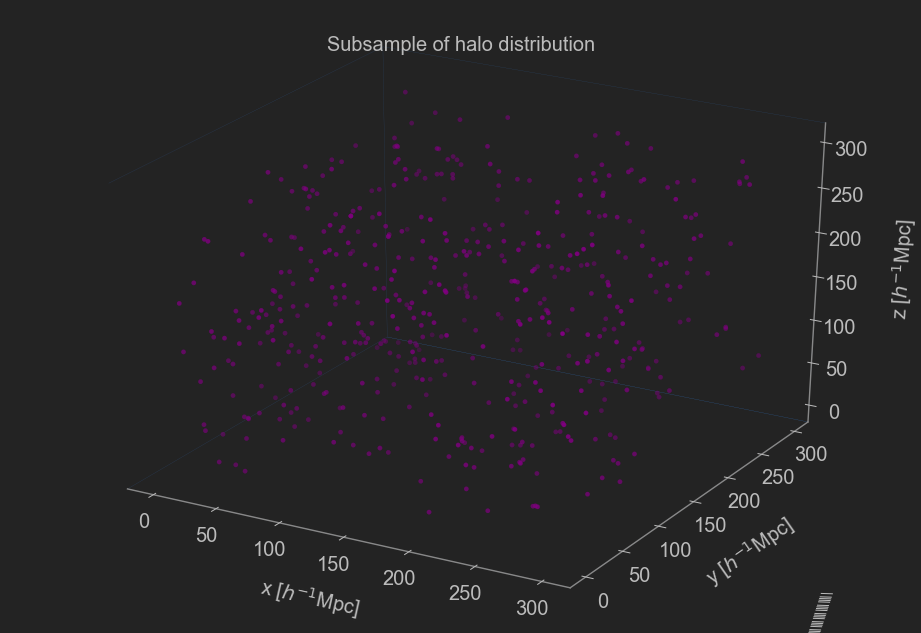

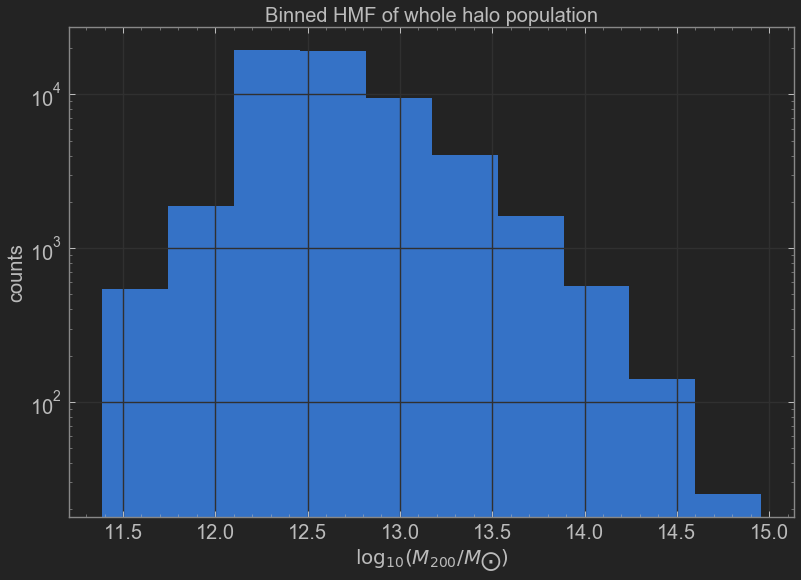

Plotting the particles' position and the binned HMF took 5.22 seconds.


In [3]:
# Subsampling the data 
n_subsamp = 500

samples = np.arange(n_halos)
idx_subsamp = np.random.choice(samples, n_subsamp)
idx_subsamp = np.sort(idx_subsamp)

x_s, y_s, z_s, log_m_s, pos_sigma_s = x[idx_subsamp], y[idx_subsamp], z[idx_subsamp], log_m[idx_subsamp], pos_sigma[idx_subsamp] 

start2 = time.time()

fig = plt.figure(figsize=(13,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_s, y_s, z_s, color="purple")
ax.set_xlabel("x [$h^{-1}$Mpc]", labelpad=30)
ax.set_ylabel("y [$h^{-1}$Mpc]", labelpad=30)
ax.set_zlabel("z [$h^{-1}$Mpc]", labelpad=30)
ax.set_title("Subsample of halo distribution")
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('b')
ax.yaxis.pane.set_edgecolor('b')
ax.zaxis.pane.set_edgecolor('b')
# ax.set_axis_off()
ax.grid(False)
plt.tight_layout()
if True:
    plt.savefig('Halo__Subsample__Distribution.png', format='png', dpi=200, pad_inches=0.1, bbox_inches='tight')
plt.show()

plt.figure(figsize=(13,9))
plt.hist(log_m)
plt.xlabel(r"$\log_{10}(M_{200}/M_{\bigodot})$")
plt.yscale("log")
plt.ylabel("counts")
plt.title("Binned HMF of whole halo population")
if False:
    plt.savefig('Halo__Binned_HMF.png', format='png', dpi=200, pad_inches=0.1, bbox_inches='tight')
plt.show()

end2 = time.time()
print(f"Plotting the particles' position and the binned HMF took {end2-start2:.2f} seconds.")

# Applying MST to halo subsample

Producing the KNN graph and building the MST took 0.01 seconds.
Extracting the edge information took 0.00 seconds.
500
Number of edges is small enough that does not require subsampling for plotting.
Plotting the MST took 5.33 seconds.


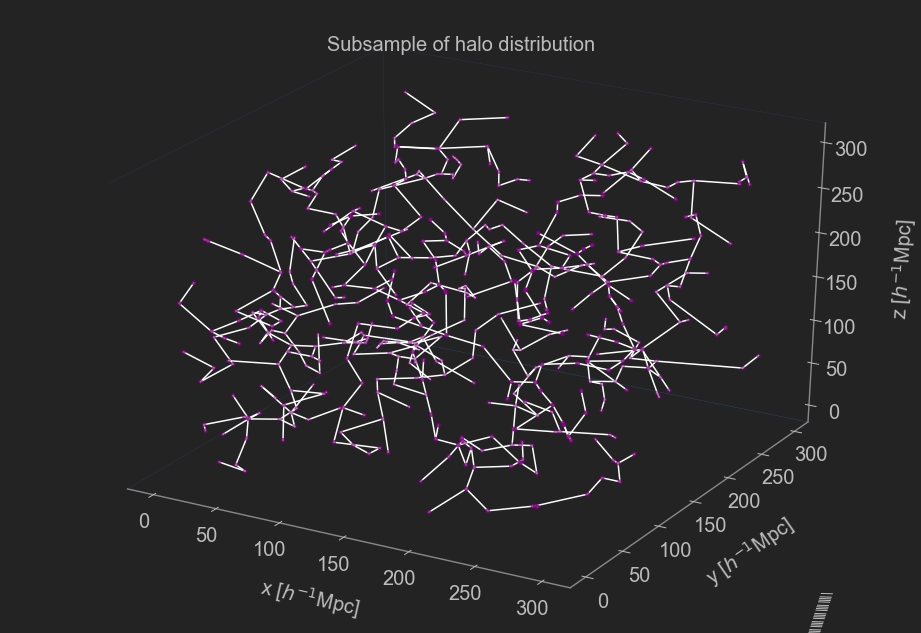

'\n    TO DO:\n    -----\n        (1) Build class for MST with above functions as methods, where each instance will be a point distribution.\n        (2) Study what part of the Alpha Complex the MST is tracing.\n        (3) Understand the difference between the DTM filtration and the Alpha Complex:\n                => Plot difference between AC and DTM persistence diagrams!\n                Q: Does the DTM filtration preserve the physical interpretation of the Alpha Complex?\n'

In [4]:
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import minimum_spanning_tree

def Build_MST(x,y,z,
             k=20):
    """
    Builds the Minimum Spanning Tree from a 3D point distribution.
    First, it constructs the K-Nearest-Neighbor graph, then it builds
    the MST from the graph outputting the Weighted Adjacency Matrix of
    the graph associated to the point distribution.
    
    Parameters:
    ----------
    x: array-like
       x-coordinates of point distribution.
    y: array-like
       y-coordinates of point distribution.
    z: array-like
       z-coordinates of point distribution.
    k: int
       Number of neighbors to consider when building graph.
       Default is k=20 as this gives best accuracy (complete
       graph) to computatonial time ratio (see Nadoo et al. 2020).
       
    Returns:
    -------
    mst: <class 'scipy.sparse.csr.csr_matrix'>
         The N x N compressed-sparse representation of the 
         undirected minimum spanning tree over the input.
    """
    start3 = time.time()
    
    # Bring coordinates into right format
    coords = np.array([x,y,z]).T
    # Build MST
    k_nearest_neighbour_graph = kneighbors_graph(coords, 20, mode="distance")
    mst = minimum_spanning_tree(k_nearest_neighbour_graph, overwrite=True)
    
    end3 = time.time()
    print(f"Producing the KNN graph and building the MST took {end3-start3:.2f} seconds.")
    return mst

def extract_edges(x, y , z, 
                 plot=True, savefig=False):
    """
    This function extracts the edges from a MST: the (x,y,z) coordinates of
    both ends of each edge, the lengths of edges and the index wrt to the nodes.
    
    Parameters:
    ----------
    mst: <class 'scipy.sparse.csr.csr_matrix'>
         The N x N compressed-sparse representation of the 
         undirected minimum spanning tree over the input.
    plot: (Optional) Boolean
          If True, plots the point distribution with its MST.
          Default is False to save computation time.
    savefig: (Optional) Boolean
             Save the plot of the MST. Se to False by default.
             
    Returns:
    -------
    Document later
    
    """
    
    # Call Build_MST method to get MST adjacency matrix
    mst = Build_MST(x, y , z)
    mst = mst.tocoo()
    start4 = time.time()
    # Find the indexes of the ends of each edges wrt to nodes
    idx_end_a, idx_end_b = mst.row, mst.col
    # Find the respectieve coordinates
    x_a, x_b = x[idx_end_a], x[idx_end_b]
    y_a, y_b = y[idx_end_a], y[idx_end_b] 
    z_a, z_b = z[idx_end_a], z[idx_end_b] 
    # Storing edge information for return
    edge_x = np.array([x_a, x_b])
    edge_y = np.array([y_a, y_b])
    edge_z = np.array([z_a, z_b])
    edge_lengths = mst.data
    edge_idxs = np.array([idx_end_a, idx_end_b])
    
    end4 = time.time()
    print(f"Extracting the edge information took {end4-start4:.2f} seconds.")
    
    print(len(x_s))
    # (Optional) Plot MST including point distribution
    if plot is True:
        start5 = time.time()
        n_edges = edge_idxs.shape[-1]
        
        fig = plt.figure(figsize=(13,9))
        ax = fig.add_subplot(111, projection='3d')
        
        # Making sure we only plot less than a certain edge threshold to avoid
        # kernel death.
        thd = 1500
        if n_edges <= thd:
            print("Number of edges is small enough that does not require subsampling for plotting.")
            for i in range(n_edges):
                e_x = np.array([x_a[i], x_b[i]])
                e_y = np.array([y_a[i], y_b[i]])
                e_z = np.array([z_a[i], z_b[i]])
                ax.plot(e_x, e_y, e_z, color="white")
            ax.scatter(x, y, z, color="purple")
            
        else:
            print(f"Number of edges exceeds {thd}. Subsampling is required to avoid kernel death.")
            for i in range(600):
                e_x = np.array([x[idx_end_a[i]], x[idx_end_b[i]]])
                e_y = np.array([y[idx_end_a[i]], y[idx_end_b[i]]])
                e_z = np.array([z[idx_end_a[i]], z[idx_end_b[i]]])
                ax.plot(e_x, e_y, e_z, color="mediumorchid")
            ax.scatter(x[:600], y[:600], z[:600], color="purple")
        
        # Setting aesthetic customs
        ax.set_xlabel("x [$h^{-1}$Mpc]", labelpad=30)
        ax.set_ylabel("y [$h^{-1}$Mpc]", labelpad=30)
        ax.set_zlabel("z [$h^{-1}$Mpc]", labelpad=30)
        ax.set_title("Subsample of halo distribution")
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        # Now set color to black (or whatever is "invisible")
        ax.xaxis.pane.set_edgecolor('b')
        ax.yaxis.pane.set_edgecolor('b')
        ax.zaxis.pane.set_edgecolor('b')
        # ax.set_axis_off()
        ax.grid(False)
        plt.tight_layout()
        if savefig is True:
                plt.savefig('Halo__Subsample__MST.png', format='png', dpi=200, pad_inches=0.1, bbox_inches='tight')
        end5 = time.time()
        
        print(f"Plotting the MST took {end5-start5:.2f} seconds.")
        plt.show()
    
    return edge_lengths, edge_x, edge_y, edge_z, edge_idxs


# Now producing a MST from this subsample
# def MST()

coords = np.array([x_s, y_s, z_s]).T
edge_lengths, edge_x, edge_y, edge_z, edge_index = extract_edges(x_s, y_s, z_s, plot=True, savefig=True)


"""
    TO DO:
    -----
        (1) Build class for MST with above functions as methods, where each instance will be a point distribution.
        (2) Study what part of the Alpha Complex the MST is tracing.
        (3) Understand the difference between the DTM filtration and the Alpha Complex:
                => Plot difference between AC and DTM persistence diagrams!
                Q: Does the DTM filtration preserve the physical interpretation of the Alpha Complex?
"""

Now that we have extracted the edges of the MST, we can plot the distribution of edge length 

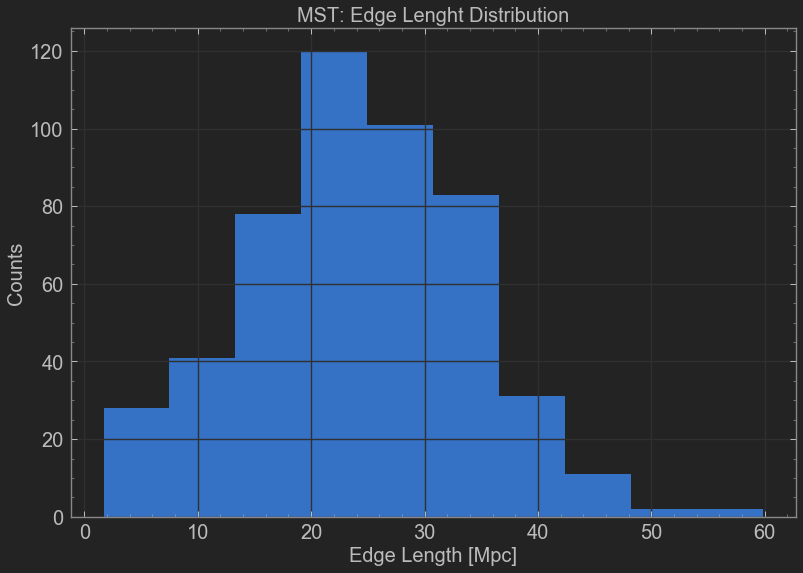

In [5]:
plt.figure()
plt.hist(edge_lengths)
plt.xlabel("Edge Length [Mpc]"); plt.ylabel("Counts")
plt.title("MST: Edge Lenght Distribution")
plt.show()

## Applying TDA on halos

### DTM filtration

Construct the DTM filtration with a unweighted Rips, (k=1, see https://github.com/GUDHI/TDA-tutorial/blob/master/Tuto-GUDHI-DTM-filtrations.ipynb) complex and find its associated simplex tree. Note that creating the Rips complex is extremely computationally heavy. Subsequently, we can compute its persistence



In [6]:
from gudhi.dtm_rips_complex import DTMRipsComplex

start6 = time.time()
dtm_rips = DTMRipsComplex(points=coords, k=1)
end6 = time.time()
print(f"Building the DTM filtration with a Rips complex took {end6-start6:.2f} seconds.")

start7 = time.time()
st = dtm_rips.create_simplex_tree(max_dimension=2)
end7 = time.time()
print(f"Building the simplex tree (data structure) of the DTM filtration took {end7-start7:.2f} seconds.")

start8 = time.time()
p = st.persistence()
end8 = time.time()
print(f"Computing the persistence of the DTM filtration took {end8-start8:.2f} seconds.")

# Plotting persistence diagram

Building the DTM filtration with a Rips complex took 0.01 seconds.
Building the simplex tree (data structure) of the DTM filtration took 2.10 seconds.
Computing the persistence of the DTM filtration took 43.63 seconds.


### Alpha Complex

To be implemented